In [ ]:
pip freeze > requirements.txt

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

In [2]:
def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "latin1", names = ["Intent", "Sentence"])
  #df.head(10)
  print(df.head(10))
  intent = df["Intent"]
  unique_intent = list(set(intent))
  sentences = list(df["Sentence"])
  
  return (intent, unique_intent, sentences)

In [3]:
intent, unique_intent, sentences = load_dataset("atis_intents_train.csv")

                Intent                                           Sentence
0          atis_flight   i want to fly from boston at 838 am and arriv...
1          atis_flight   what flights are available from pittsburgh to...
2     atis_flight_time   what is the arrival time in san francisco for...
3         atis_airfare            cheapest airfare from tacoma to orlando
4         atis_airfare   round trip fares from pittsburgh to philadelp...
5          atis_flight   i need a flight tomorrow from columbus to min...
6        atis_aircraft   what kind of aircraft is used on a flight fro...
7          atis_flight   show me the flights from pittsburgh to los an...
8          atis_flight              all flights from boston to washington
9  atis_ground_service   what kind of ground transportation is availab...


In [4]:
print(sentences[:5])

[' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning', ' what flights are available from pittsburgh to baltimore on thursday morning', ' what is the arrival time in san francisco for the 755 am flight leaving washington', ' cheapest airfare from tacoma to orlando', ' round trip fares from pittsburgh to philadelphia under 1000 dollars']


***PREPROCESSING***

In [5]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
stemmer = LancasterStemmer()

In [7]:
def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    #stemming
    words.append([i.lower() for i in w])
    
  return words

In [8]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])

4844
[['i', 'want', 'to', 'fly', 'from', 'boston', 'at', '838', 'am', 'and', 'arrive', 'in', 'denver', 'at', '1110', 'in', 'the', 'morning'], ['what', 'flights', 'are', 'available', 'from', 'pittsburgh', 'to', 'baltimore', 'on', 'thursday', 'morning']]


In [9]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [10]:
def max_length(words):
  return(len(max(words, key = len)))

In [11]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 884 and Maximum length = 48


In [12]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [13]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [14]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [15]:

padded_doc = padding_doc(encoded_doc, max_length)

In [16]:
padded_doc[:5]

array([[ 12,  68,   1,  38,   2,   9,  69, 397,  84,  17,  78,  16,  13,
         69, 511,  16,   4,  35,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  6,   3,  26,  56,   2,  19,   1,  22,   5,  75,  35,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  6,  21,   4, 398, 182,  16,  11,  15,  39,   4, 512,  84,   8,
         33,  32,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 51, 277,   2, 180,   1, 126,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   

In [17]:

print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (4844, 48)


In [18]:
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [19]:
output_tokenizer.word_index

{'atis_abbreviation': 7,
 'atis_aircraft': 4,
 'atis_airfare': 2,
 'atis_airline': 3,
 'atis_flight': 1,
 'atis_flight_time': 8,
 'atis_ground_service': 6,
 'atis_quantity': 5}

In [20]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [21]:
import numpy as np
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [22]:
encoded_output.shape

(4844, 1)

***ONE HOT ENCODING***

In [23]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [24]:
output_one_hot = one_hot(encoded_output)

In [25]:
output_one_hot.shape

(4844, 8)

In [26]:
from sklearn.model_selection import train_test_split


In [27]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

In [28]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (3875, 48) and train_Y = (3875, 8)
Shape of val_X = (969, 48) and val_Y = (969, 8)


***LSTM MODEL CREATION***

In [29]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(8, activation = "softmax"))
  
  return model

In [30]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 128)           113152    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 384,808
Trainable params: 271,656
Non-trainable params: 113,152
_________________________________________________________________


In [31]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Epoch 1/100
122/122 [==============================] - 17s 109ms/step - loss: 1.4578 - accuracy: 0.5880 - val_loss: 0.9533 - val_accuracy: 0.7761

Epoch 00001: val_loss improved from inf to 0.95331, saving model to model.h5
Epoch 2/100
122/122 [==============================] - 12s 100ms/step - loss: 1.0754 - accuracy: 0.7380 - val_loss: 0.6627 - val_accuracy: 0.7936

Epoch 00002: val_loss improved from 0.95331 to 0.66270, saving model to model.h5
Epoch 3/100
122/122 [==============================] - 12s 101ms/step - loss: 0.8223 - accuracy: 0.7621 - val_loss: 0.5848 - val_accuracy: 0.8349

Epoch 00003: val_loss improved from 0.66270 to 0.58475, saving model to model.h5
Epoch 4/100
122/122 [==============================] - 12s 100ms/step - loss: 0.6618 - accuracy: 0.8032 - val_loss: 0.4787 - val_accuracy: 0.8462

Epoch 00004: val_loss improved from 0.58475 to 0.47868, saving model to model.h5
Epoch 5/100
122/122 [==============================] - 12s 101ms/step - loss: 0.5897 - accur

In [69]:
model = load_model("model.h5")

In [70]:
def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  #print(test_word)
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
  x = padding_doc(test_ls, max_length)
  
  pred = model.predict(x)

  return pred
  
  

In [74]:
def get_final_intent(pred, classes):

  predictions = pred[0]
 
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
  score=0
  max=0
  for i in range(pred.shape[1]):
    #print()

    if predictions[i]>max:
      max=predictions[i]
      score=i

  return classes[score],predictions[score]
  
    
    #print("%s has confidence score : %s" % (classes[i], (predictions[i])))
    #print()
  
  #print('Intent : ',classes[score])
  #print('Confidence Score :',predictions[score])
  #print()
  #print()
  #return classes[score]


***TRUE-POSITIVE RATE EVALUATION***

In [72]:
#TruePositive Rate on testData_ATIS

dfs=pd.read_csv('testDataInCSV.csv')
tp=0
for i in range(0,len(dfs)):
  utterance=dfs._get_value(i,'Sentence')
  pred=predictions(utterance)
  x=get_final_intent(pred,unique_intent)
  label=dfs._get_value(i,'Intent')
  if x==label:
    tp=tp+1

print('Number of True Positives :',tp)
tpr=(tp)/(len(dfs))
print('True Positive Rate:',tpr)
  


Number of True Positives : 791
True Positive Rate: 0.8857782754759238


In [79]:
dfs.head(10)

,Index No.,Intent,Sentence
0,0,atis_flight,i would like to find a flight from charlotte t...
1,1,atis_airfare,on april first i need a ticket from tacoma to ...
2,2,atis_flight,on april first i need a flight going from phoe...
3,3,atis_flight,i would like a flight traveling one way from p...
4,4,atis_flight,i would like a flight from orlando to salt lak...
5,5,atis_flight,i need a flight from toronto to newark one way...
6,6,atis_flight,monday morning i would like to fly from columb...
7,7,atis_flight,on wednesday april sixth i would like to fly f...
8,8,atis_flight,after 12 pm on wednesday april sixth i would l...
9,9,atis_flight,are there any flights from long beach to colum...


***PREDICTING THE INTENT CLASS***

In [75]:
query='how much does it cost for a single person to travel from chennai to mumbai'
pred = predictions(query)
class_name,conf_score=get_final_intent(pred, unique_intent)

print(query)
print('Intent : ',class_name)
print('Confidence Score :',conf_score)



how much does it cost for a single person to travel from chennai to mumbai
Intent :  atis_airfare
Confidence Score : 0.9999945


In [77]:
query='show me the flights available at the new delhi ariport on thursday'
pred = predictions(query)
class_name,conf_score=get_final_intent(pred, unique_intent)

print(query)
print('Intent : ',class_name)
print('Confidence Score :',conf_score)



show me the flights available at the new delhi ariport on thursday
Intent :  atis_flight
Confidence Score : 0.99999416


In [78]:
query='what is the abbreviation of abn'
pred=predictions(query)
class_name,conf_score=get_final_intent(pred,unique_intent)

print(query)
print('Intent : ',class_name)
print('Confidence Score :',conf_score)



what is the abbreviation of abn
Intent :  atis_abbreviation
Confidence Score : 0.9410036


***TRAINING AND VALIDATION ACCURACY GRAPH PLOTS***

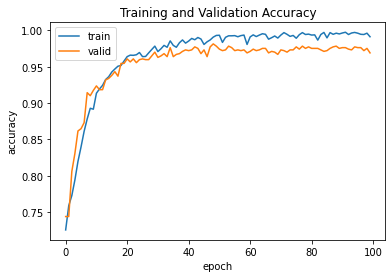

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



***TRAINING AND VALIDATION LOSS GRAPH PLOTS***

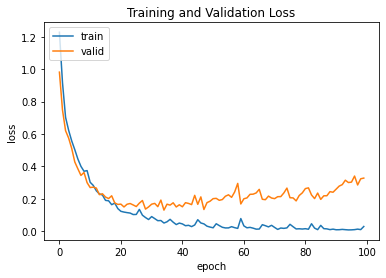

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()